In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from scipy.optimize import curve_fit
import sympy as smp
from sympy import diff, print_latex
import fit_lineare as ft
plt.style.use(["grid"])

<h1>Tabella

In [2]:
def tabulamisure(*args,**kwargs):
    n=len(args)
    sigfigs=3*np.ones(n)
    Header=[]
    mostranum=False
    for kw in kwargs:
        if kw=='header':
            Header=kwargs[kw]
        if kw=='mostranum':
            mostranum=kwargs[kw]
        if kw=='dec':
            sigfigs=kwargs[kw]
    if mostranum:
        riga="\\begin{tabular}{l|"
    else:
        riga="\\begin{tabular}{l"
    for i in range(n):
            riga+="c|"
    print(riga[:-1],"}")
    riga=" "
    for titolo in Header:
        if mostranum:
            riga+=f"{titolo} &"
        else:
            riga+=f" & {titolo}"
    if mostranum:
        print(riga[:-1],"\\\\")
    else:
        print(riga,"\\\\")
    print("\\hline \\hline ")
    #dati
    arr=np.array(args).T
    for i,row in enumerate(arr):
        riga=""
        if mostranum:
            riga+=str(i+1)
        for j,elem in enumerate(row):
            elem=format(elem, f'.{int(sigfigs[j])}f')
            riga+=f" & {elem}"
        print(riga,"\\\\")
    print("\\hline \\hline ")
    print("$\mu$",*["& "+str(np.array(args)[i].mean().round(int(sigfigs[i])+1)) for i in range(n)],"\\\\")
    print("S",*["& "+str(np.array(args)[i].std(ddof=1).round(int(sigfigs[i])+2)) for i in range(n)],"\\\\ \n\\end{tabular}")

<h1>Fit

In [317]:
def func(x,m,c):
    return m*x+c
def media_pesata(sigma_y,arr):
    if not np.isscalar(sigma_y):
        return np.average(arr,weights=1/sigma_y**2)
    else:
        return np.average(arr)
def Cov_p(sigma_y,x,y):
    return media_pesata(sigma_y,x*y)-media_pesata(sigma_y,x)*media_pesata(sigma_y,y)
def fit(xdata,ydata,sigmay,xlabell="x",ylabell="y",plot=True, titolo = None):
    popt,popv = curve_fit(func,xdata,ydata,sigma = sigmay, absolute_sigma = True)
    m,c =popt
    sigma_m,sigma_c =  np.sqrt(np.diag(popv))
    if plot:
        plt.figure(figsize=(13,8))
        plt.title(titolo)
        xmin, xmax = xdata.min(),xdata.max()
        Xr =np.linspace(xmin-.2*(xmax-xmin),xmax+.2*(xmax-xmin),3)
        plt.plot(Xr, m*Xr+c,color ="tab:red",label="linea di miglior fit")
        plt.errorbar(xdata,ydata,yerr=sigmay,color="tab:blue",fmt='.',label="dati")
        plt.xlabel(xlabell)
        plt.ylabel(ylabell)
        plt.legend()
        print(f"m = {m} +/- {sigma_m}\nc = {c} +/- {sigma_c}\nCov(m,c) = {popv[0][1]}\n")
    return m,sigma_m,c,sigma_c,popv[0][1]
def fit_iter(xdata,ydata,sigmax,sigmay,plot=True, nuoveincertezze=True,titolo = None):
    m_0 = (ydata.max()-ydata.min())/(xdata.max()-xdata.min())
    #print(sigmay,"~",m_0*sigmax)
    #print("m_0 = ",m_0)
    m = m_0 
    for _ in range(2):
        sigmay_new = np.sqrt(sigmay**2+(m*sigmax)**2)
        m,sigma_m,c,sigma_c,cov_mc = fit(xdata,ydata,sigmay_new,plot=False)
    if plot:
        ## SE NUOVE INCERTEZZE ##
        if nuoveincertezze:
            sigmay_new = np.sqrt(sigmay**2+(m*sigmax)**2)
            m,sigma_m,c,sigma_c,cov_mc = fit(xdata,ydata,sigmay_new,plot=True)
        else:
            plt.figure(figsize=(13,8))
            plt.title(titolo)
            xmin, xmax = xdata.min(),xdata.max()
            Xr =np.linspace(xmin-.2*(xmax-xmin),xmax+.2*(xmax-xmin),3)
            plt.plot(Xr, m*Xr+c,color ="tab:red",label="linea di miglior fit")
            plt.errorbar(xdata,ydata,xerr=sigmax,yerr=sigmay,color="tab:blue",fmt='.',label="dati")
            print(f"m = {m} +/- {sigma_m}\nc = {c} +/- {sigma_c}\nCov(m,c) = {cov_mc}")
    return m,sigma_m,c,sigma_c,cov_mc,sigmay_new
def fit_c(dati,sigma):
    c =media_pesata(sigma,dati)
    sigma_c =1/np.sqrt(sum(1/sigma**2))
    Xr =np.linspace(0.9,len(dati)+0.1,3)
    plt.plot(Xr,c*np.ones(3),color="tab:red")
    plt.errorbar(range(1,1+len(dati)),dati,yerr=sigma,fmt=".",color="tab:blue")
    plt.xlabel("N. misura")
    return c,sigma_c
def residui(xdata,ydata,sigmax,sigmay, titolo = None):
    plt.figure(figsize=(13,8))
    plt.title(titolo)
    m,sigma_m,c,sigma_c,cov_mc,sigmay = fit_iter(xdata,ydata,sigmax,sigmay,plot=False)
    plt.plot([xdata.min()-.2*(xdata.max()-xdata.min()),xdata.max()+.2*(xdata.max()-xdata.min())],[0,0],color="tab:red")
    plt.errorbar(xdata,(ydata-m*xdata-c)/sigmay,yerr=1,fmt=".",color="tab:blue")
    locs, labels = plt.yticks()
    ticklabels = [f"{loc}$\sigma$" for loc in locs]
    plt.gca().set_yticklabels(ticklabels)
    plt.ylabel("Residui normalizzati")
def fit_post(xdata,ydata,sigmax,sigmay,plot=True,titolo = None):
    m,sigma_m,c,sigma_c,cov_mc,sigmay_new = fit_iter(xdata,ydata,sigmax,sigmay,plot=False)
    sigma_post = np.sqrt(sum((ydata-m*xdata-c)**2)/(len(xdata)-2))
    m,sigma_m,c,sigma_c,cov_mc = fit(xdata,ydata,sigma_post*np.ones(len(xdata)),plot=plot,titolo=titolo)
    if plot:
        residui(xdata,ydata,np.zeros(len(xdata)),sigma_post*np.ones(len(xdata)),titolo=titolo)
    return m,sigma_m,c,sigma_c,cov_mc,sigma_post

(1.0317073170731708, 0.08381163549234939)

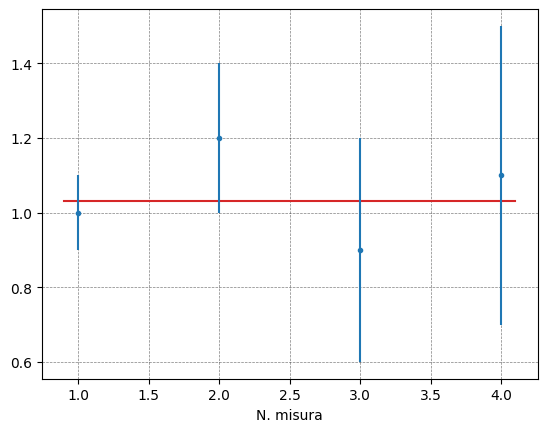

In [4]:
A = np.array([1,1.2,0.9,1.1])
S = np.array([0.1,0.2,0.3,0.4])
fit_c(A,S)

m = 1.000558983877766 +/- 0.08194769983525636
c = -0.0670311547722553 +/- 0.26328032939176893
Cov(m,c) = -0.019998425457619304



(1.000558983877766,
 0.08194769983525636,
 -0.0670311547722553,
 0.26328032939176893,
 -0.019998425457619304,
 array([0.2236318 , 0.22370681, 0.28292178, 0.14146089]))

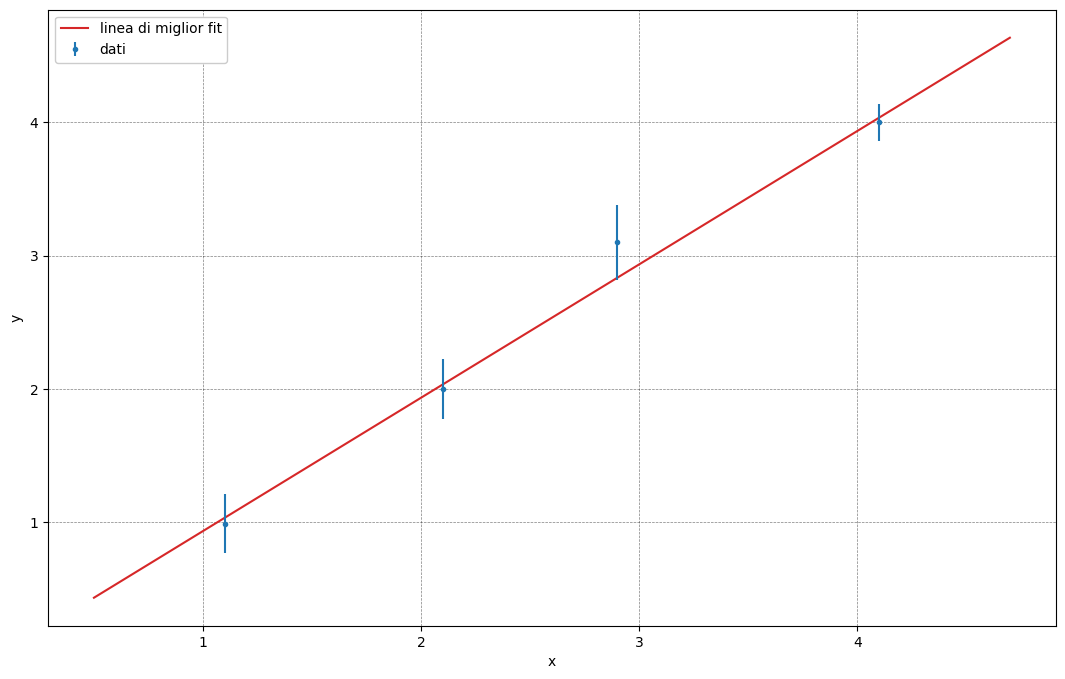

In [170]:
A = np.array([1.1,2.1,2.9,4.1])
B = np.array([0.99,2,3.1,4])
sigmaA =np.array([0.1,0.2,0.2,0.1])
sigmaB=np.array([0.2,0.1,0.2,0.1])
fit_iter(A,B,sigmaA,sigmaB,nuoveincertezze=True)


# Propagazione incertezze


In [6]:
def f(x,y,z):
    return x*y+z
a,b,c = smp.symbols("m \Delta{T} c")
Cov = [smp.symbols("\sigma_{mc} j"),(a,c)]
L = [a,b,c]
sigma = smp.symbols("\sigma_m \sigma_{\Delta{T}} \sigma_c")
m = f(a,b,c)
sigma_m = sum([smp.simplify(diff(m,x_i))**2*sigma[i]**2 for i,x_i in enumerate(L)])
sigma_m +=sum([2*smp.simplify(diff(m,Cov[i+1][0]))*smp.simplify(diff(m,Cov[i+1][1]))*Cov[0][i] for i in range(len(Cov)-1)])
print_latex(sigma_m)
sigma_m

\Delta{T}^{2} \sigma_{m}^{2} + 2 \Delta{T} \sigma_{mc} + \sigma_{c}^{2} + \sigma_{\Delta{T}}^{2} m^{2}


\Delta{T}**2*\sigma_m**2 + 2*\Delta{T}*\sigma_{mc} + \sigma_c**2 + \sigma_{\Delta{T}}**2*m**2

# Istogrammi


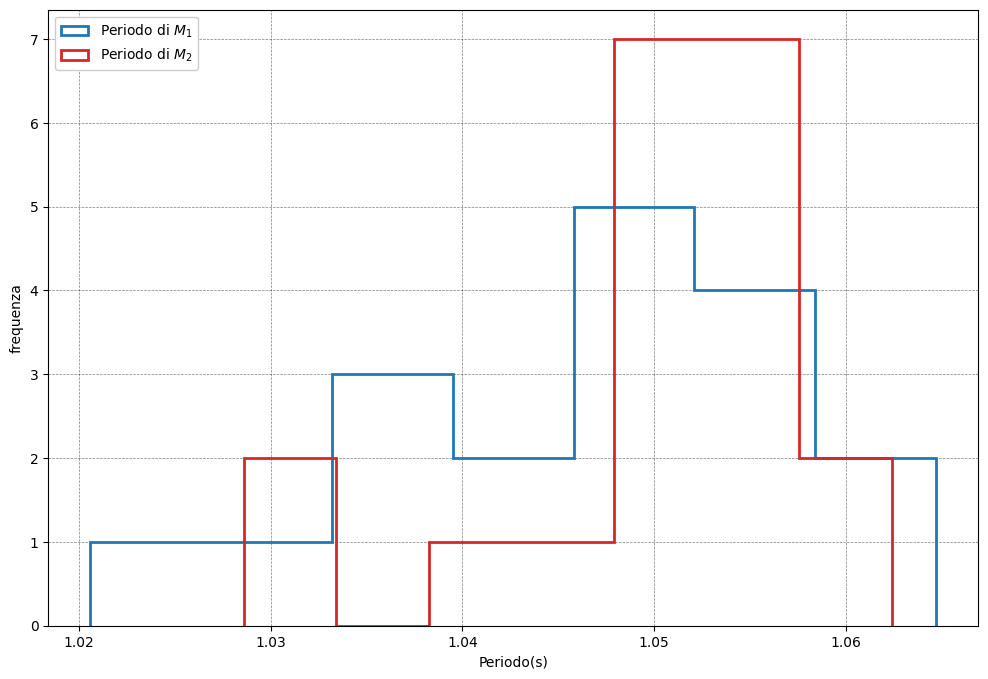

\begin{tabular}{l|c|c }
 n. misura &T$_5$(M$_1$) [s] &T$_5$(M$_2$) [s]  \\
\hline \hline 
1 & 5.347 & 5.159 \\
2 & 5.144 & 5.246 \\
3 & 5.166 & 5.261 \\
4 & 5.195 & 5.263 \\
5 & 5.281 & 5.267 \\
6 & 5.319 & 5.268 \\
7 & 5.290 & 5.268 \\
8 & 5.252 & 5.282 \\
9 & 5.196 & 5.143 \\
10 & 5.246 & 5.267 \\
11 & 5.290 & 5.305 \\
12 & 5.246 & 5.286 \\
13 & 5.350 & 5.246 \\
14 & 5.131 & 5.194 \\
15 & 5.225 & 5.260 \\
16 & 5.239 & 5.275 \\
17 & 5.225 & 5.254 \\
18 & 5.249 & 5.216 \\
19 & 5.313 & 5.312 \\
20 & 5.285 & 5.261 \\
\hline \hline 
$\mu$ & 5.2494 & 5.2516 \\
S & 0.06212 & 0.04327 \\ 
\end{tabular}


In [211]:
plt.figure(figsize=(12,8))
Periodo_M1 = np.array([1.0694 ,1.0288 ,1.0332 ,1.039 ,1.0562 ,1.0638 ,1.058 ,1.0504 ,1.0392 ,1.0492 ,1.058 ,1.0492 ,1.07 ,1.0262 ,1.045 ,1.0478 ,1.045 ,1.0498 ,1.0626 ,1.057])
Periodo_M2 = np.array([1.0318 ,1.0492 ,1.0522 ,1.0526 ,1.0534 ,1.0536 ,1.0536 ,1.0564 ,1.0286 ,1.0534 ,1.061 ,1.0572 ,1.0492 ,1.0388 ,1.052 ,1.055 ,1.0508 ,1.0432 ,1.0624 ,1.0522])
plt.hist(Periodo_M1,bins=np.arange(1.0206,1.0206+8*0.0063,0.0063),histtype="step",color="tab:blue",lw=2,label="Periodo di $M_1$")
plt.hist(Periodo_M2,bins=7,histtype="step",color="tab:red",lw=2,label="Periodo di $M_2$")
plt.xlabel("Periodo(s)")
plt.ylabel("frequenza")
plt.legend()
plt.show()
tabulamisure(5*Periodo_M1,5*Periodo_M2,header=["n. misura", "T$_5$(M$_1$) [s]","T$_5$(M$_2$) [s]"],mostranum=True,dec=[3,3])

In [10]:
def toglivirgole(nomefile):
    reading_file = open(nomefile, "r")

    new_file_content = ""
    for line in reading_file:
        stripped_line = line.strip()
        new_line = stripped_line.replace(",", ".")
        new_file_content += new_line +"\n"
    reading_file.close()

    writing_file = open(nomefile, "w")
    writing_file.write(new_file_content)
    writing_file.close()

In [11]:
temp=23
offset_h=9.3

m = 172.41922478930425 +/- 0.38349050700550585
c = -0.01077277177657891 +/- 0.0022213617607390267
Cov(m,c) = -0.0008157341059810751



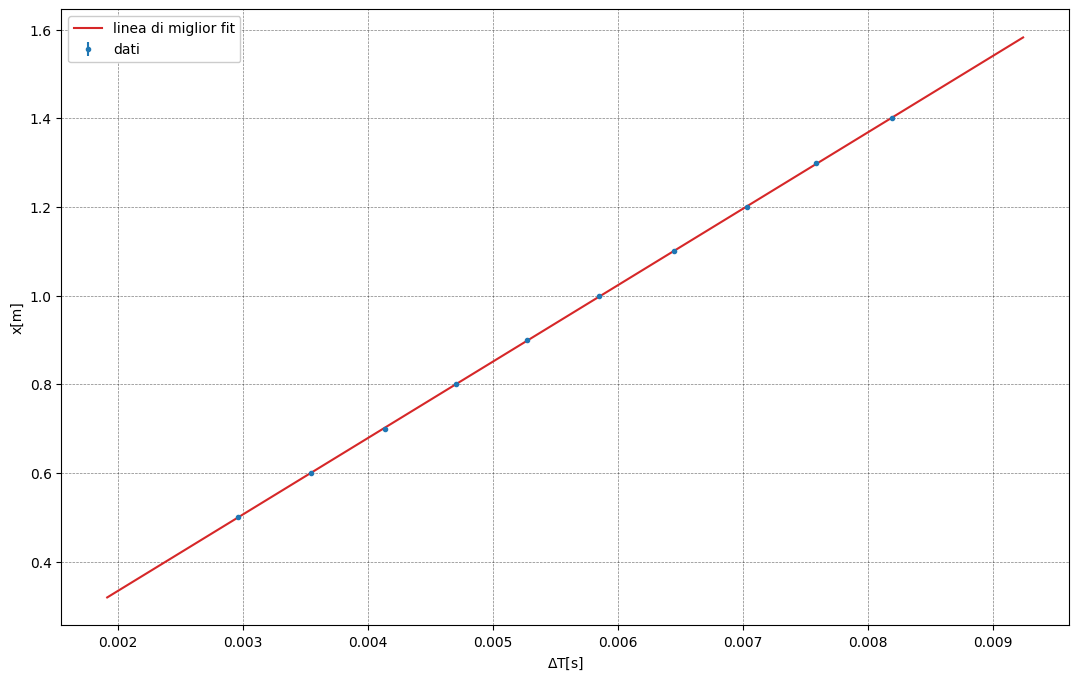

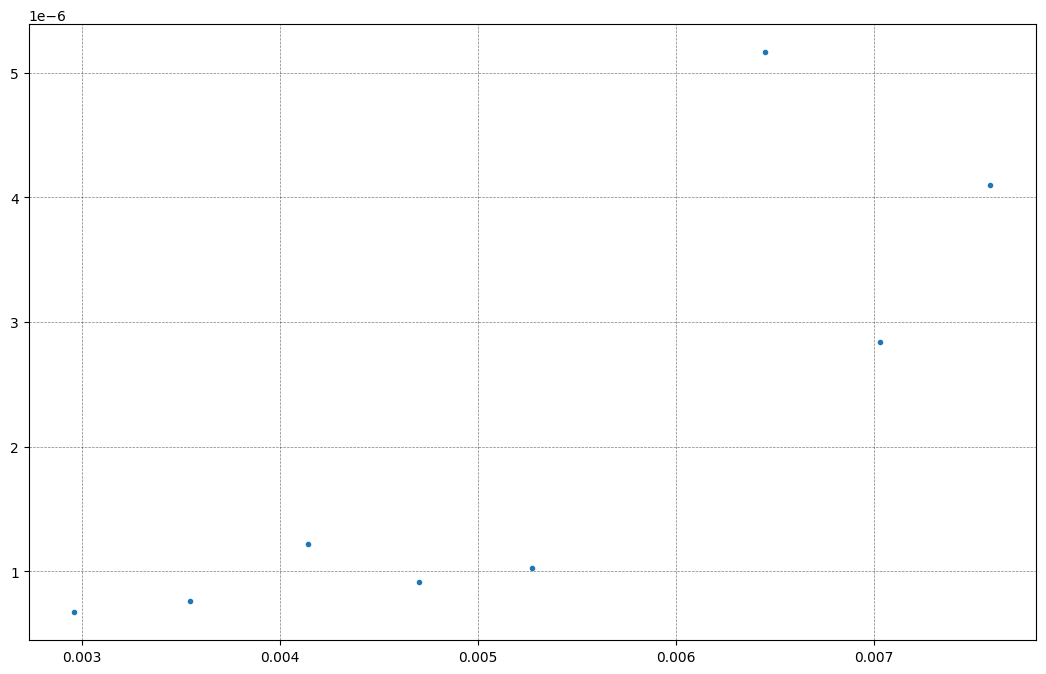

In [171]:
x=np.array([50,60,70,80,90,100,110,120,130,140])
sigma_X = 0.002*np.ones(len(x))
Delta_T = []
sigma_DeltaT = []
ris_DeltaT = 10**(-6) 
devstandard=[]
for l in x:
    toglivirgole(f'{l}cm.txt')
    df = pd.read_csv(f'{l}cm.txt',header=1,sep='\t') #il separatore in questo caso era un "tab" (\t)
    df = df.rename(columns={"Tempo ( s )": "t", "Tempo trascorso ( s )": "DeltaT"})
    #df.plot(x="t",y="DeltaT",linestyle="None",marker=".")
    DeltaT = df.DeltaT.to_numpy()

    Delta_T.append(DeltaT.mean())
    
    devstd = DeltaT.std(ddof=1)
    sigma_a = devstd/np.sqrt(len(DeltaT))
    devstandard.append(devstd)
    if devstd>=ris_DeltaT:
        sigma_b = ris_DeltaT/np.sqrt(12)
    else:
        sigma_b = 0
    sigma_DeltaT.append(np.sqrt(sigma_a**2+sigma_b**2))

#print(Delta_T,'\n\n',sigma_DeltaT)
x= x*10**(-2)
#print(172*np.array(sigma_DeltaT))
fit_iter(np.array(Delta_T),x,np.array(sigma_DeltaT),sigma_X)
plt.xlabel("$\Delta$T[s]")
plt.ylabel("x[m]")
plt.figure(figsize=(13,8))
#devstandard.pop(5); Delta_T.pop(5)
#devstandard.pop(-1); Delta_T.pop(-1)
#plt.plot(Delta_T,devstandard,'.')

[0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002] ~ [7.97788064e-06 9.12847098e-06 5.17501461e-05 1.10514706e-05
 5.11458785e-05 8.59138169e-04 7.97776192e-05 6.02478028e-05
 6.98035960e-05 5.74578975e-04]
m_0 =  171.91527390359718


C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\512308589.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(ticklabels)


Text(0.5, 0, '$\\Delta$\xa0T[s]')

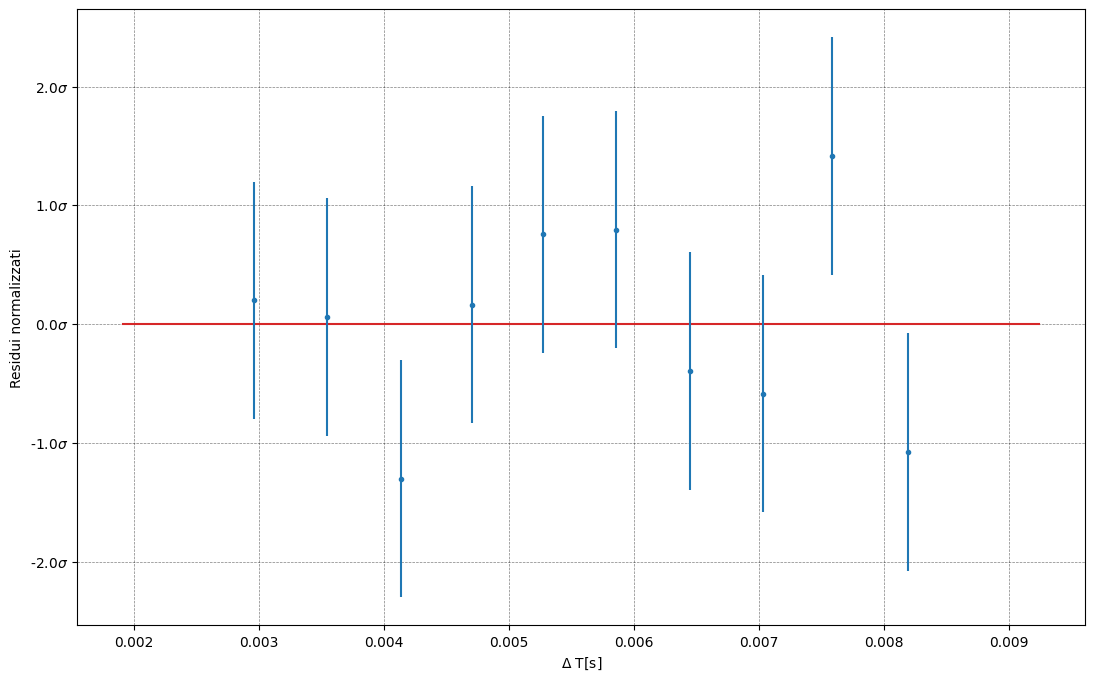

In [37]:
residui(np.array(Delta_T),x,np.array(sigma_DeltaT),sigma_X)
plt.xlabel("$\Delta$ T[s]")

In [14]:
def XdaDeltaT(DeltaT,sigma_DeltaT=0):
    m = 172.41925974880363
    sigma_m =0.38354076223334843
    c = -0.010773018941511293 
    sigma_c = 0.0022217727498944823
    sigma_mc = -0.0008159986013500011
    return m*DeltaT+c,(DeltaT**2)*(sigma_m**2) + 2*DeltaT*sigma_mc + sigma_c**2 + (m**2)*sigma_DeltaT**2

In [96]:
def f(m,DeltaT1,DeltaT2,t1,t2):
    return m*(DeltaT2-DeltaT1)/(t2-t1)
m,DeltaT1,DeltaT2,t1,t2 = smp.symbols("m \Delta{T_{1}} \Delta{T_{2}} t_{1} t_{2} ")

#Cov = [smp.symbols("\sigma_{mc} j"),(a,c)]
L = [m,DeltaT1,DeltaT2,t1,t2]
sigma = smp.symbols("\sigma_m \sigma_{\Delta{T_{1}}} \sigma_{\Delta{T_{2}}} \sigma_{t_1} \sigma_{t_2}")
sigma_DeltaT,sigma_t = smp.symbols("\sigma_{\Delta{T}} \sigma_t")
v = f(m,DeltaT1,DeltaT2,t1,t2)
sigma_v = sum([smp.simplify(diff(v,x_i))**2*sigma[i]**2 for i,x_i in enumerate(L)])
#sigma_m +=sum([2*smp.simplify(diff(v,Cov[i+1][0]))*smp.simplify(diff(v,Cov[i+1][1]))*Cov[0][i] for i in range(len(Cov)-1)])
print_latex(sigma_v)
sigma_v.subs({sigma[1]:sigma_DeltaT,sigma[2]:sigma_DeltaT,sigma[3]:sigma_t,sigma[4]:sigma_t})

\frac{\sigma_{m}^{2} \left(\Delta{T_{1}} - \Delta{T_{2}}\right)^{2}}{\left(t_{1} - t_{2}\right)^{2}} + \frac{\sigma_{\Delta{T_{1}}}^{2} m^{2}}{\left(t_{1} - t_{2}\right)^{2}} + \frac{\sigma_{\Delta{T_{2}}}^{2} m^{2}}{\left(t_{1} - t_{2}\right)^{2}} + \frac{\sigma_{t_1}^{2} m^{2} \left(\Delta{T_{1}} - \Delta{T_{2}}\right)^{2}}{\left(t_{1} - t_{2}\right)^{4}} + \frac{\sigma_{t_2}^{2} m^{2} \left(\Delta{T_{1}} - \Delta{T_{2}}\right)^{2}}{\left(t_{1} - t_{2}\right)^{4}}


\sigma_m**2*(\Delta{T_{1}} - \Delta{T_{2}})**2/(t_{1} - t_{2})**2 + 2*\sigma_t**2*m**2*(\Delta{T_{1}} - \Delta{T_{2}})**2/(t_{1} - t_{2})**4 + 2*\sigma_{\Delta{T}}**2*m**2/(t_{1} - t_{2})**2

In [245]:
def IncertezzaV(Delta_T1, Delta_T2, t_1, t_2):
    m = 172.41925974880363
    sigma_m =0.38354076223334843
    v = m * (Delta_T2-Delta_T1)/(t_2-t_1)
    sigma_Delta_T = 2.89*10**(-7)
    sigma_tp = 2.89*10**(-5)
    return abs(v) * np.sqrt((sigma_m/m)**2+2*(sigma_tp/(t_1-t_2))**2+2*(sigma_Delta_T/(Delta_T1-Delta_T2))**2)

In [349]:
from matplotlib import colors
def background_gradient(s, m=0, M=1, cmap='turbo', low=1.5, high=0):
    print(s.shape)
    if m is None:
        m = s.min().min()
    if M is None:
        M = s.max().max()
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = s.apply(norm)

    cm = plt.cm.get_cmap(cmap)
    c = normed.applymap(lambda x: colors.rgb2hex(cm(x)))
    ret = c.applymap(lambda x: 'background-color: %s' % x)
    return ret

In [ ]:
def CoviaranzaViVj(V0,V1,T0,T1,T2,T3,t0,t1,t2,t3):
    x = 


C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\683668290.py:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df = df.drop(df[df.t <intervalli[h][0] ].index | df[df.t > intervalli[h][1]].index)
C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\3492270241.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(ticklabels)


m = 0.05436229165686097 +/- 0.0005003006489873232
c = 0.06761232630575514 +/- 0.002327932669917335
Cov(m,c) = -1.1527027509789547e-06
m = 0.05273173753611473 +/- 0.0015303146579506903
c = 0.07616166251373951 +/- 0.007124727522496366
Cov(m,c) = -1.078504269761021e-05

(23, 23)


C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\683668290.py:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df = df.drop(df[df.t <intervalli[h][0] ].index | df[df.t > intervalli[h][1]].index)
C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\683668290.py:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df = df.drop(df[df.t <intervalli[h][0] ].index | df[df.t > intervalli[h][1]].index)
C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\683668290.py:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df = df.drop(df[df.t <intervalli[h][0] ].index | df[df.t > intervalli[h][1]].index)
C:\Users\nicc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1.00,0.14,0.14,0.15,0.15,0.15,0.16,0.16,0.16,0.17,0.17,0.17,0.15,0.17,0.17,0.18,0.18,0.19,0.18,0.18,0.18,0.19,0.19
1,0.14,1.00,0.15,0.15,0.16,0.16,0.16,0.16,0.16,0.17,0.17,0.17,0.15,0.18,0.18,0.18,0.18,0.20,0.19,0.19,0.19,0.19,0.19
2,0.14,0.15,1.00,0.15,0.16,0.16,0.16,0.16,0.17,0.17,0.18,0.17,0.15,0.18,0.18,0.18,0.18,0.20,0.19,0.19,0.19,0.19,0.19
3,0.15,0.15,0.15,1.00,0.16,0.16,0.17,0.17,0.17,0.18,0.18,0.18,0.15,0.18,0.18,0.19,0.19,0.20,0.19,0.19,0.19,0.20,0.20
4,0.15,0.16,0.16,0.16,1.00,0.17,0.17,0.17,0.17,0.18,0.18,0.18,0.16,0.19,0.19,0.19,0.19,0.21,0.20,0.20,0.20,0.20,0.20
5,0.15,0.16,0.16,0.16,0.17,1.00,0.17,0.17,0.17,0.18,0.18,0.18,0.16,0.19,0.19,0.19,0.19,0.21,0.20,0.20,0.20,0.20,0.20
6,0.16,0.16,0.16,0.17,0.17,0.17,1.00,0.18,0.18,0.19,0.19,0.19,0.17,0.20,0.20,0.20,0.20,0.22,0.20,0.21,0.21,0.21,0.21
7,0.16,0.16,0.16,0.17,0.17,0.17,0.18,1.00,0.18,0.19,0.19,0.19,0.17,0.20,0.20,0.20,0.20,0.22,0.20,0.21,0.21,0.21,0.21
8,0.16,0.16,0.17,0.17,0.17,0.17,0.18,0.18,1.00,0.19,0.19,0.19,0.17,0.20,0.20,0.20,0.20,0.22,0.21,0.21,0.21,0.21,0.21
9,0.17,0.17,0.17,0.18,0.18,0.18,0.19,0.19,0.19,1.00,0.20,0.20,0.17,0.21,0.21,0.21,0.21,0.23,0.22,0.22,0.22,0.22,0.22


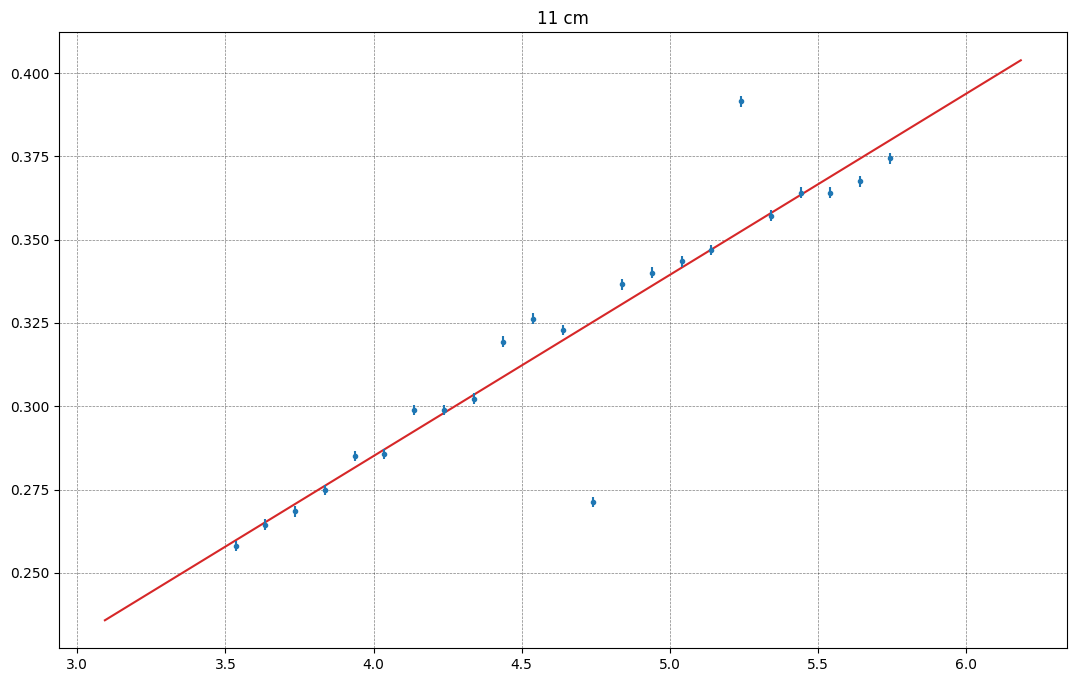

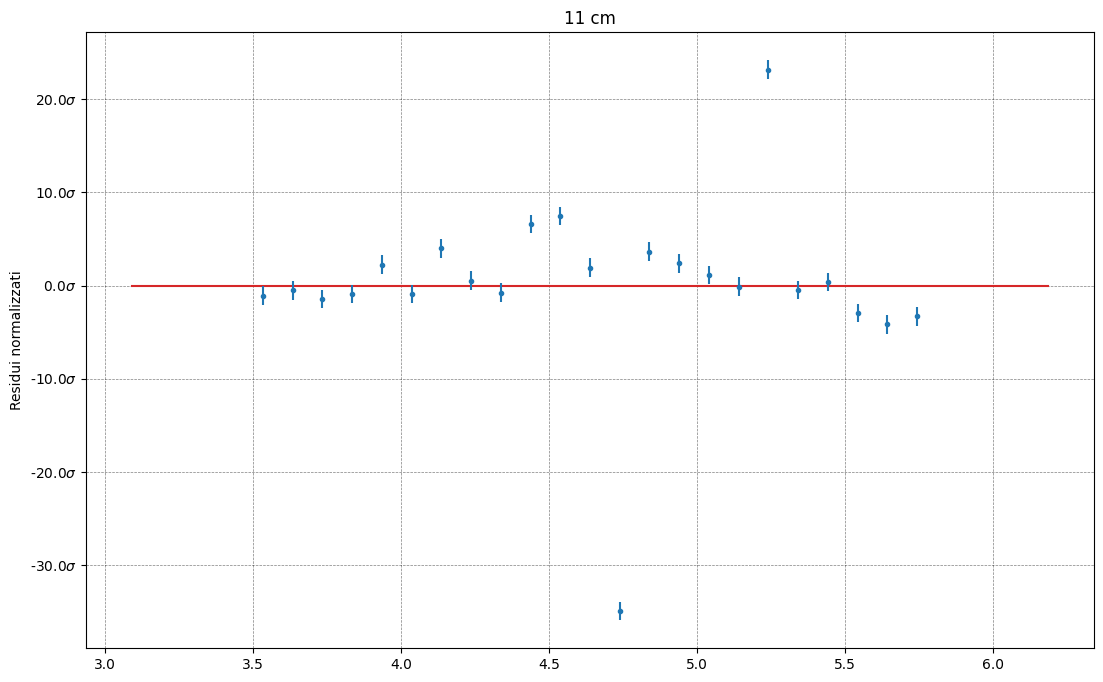

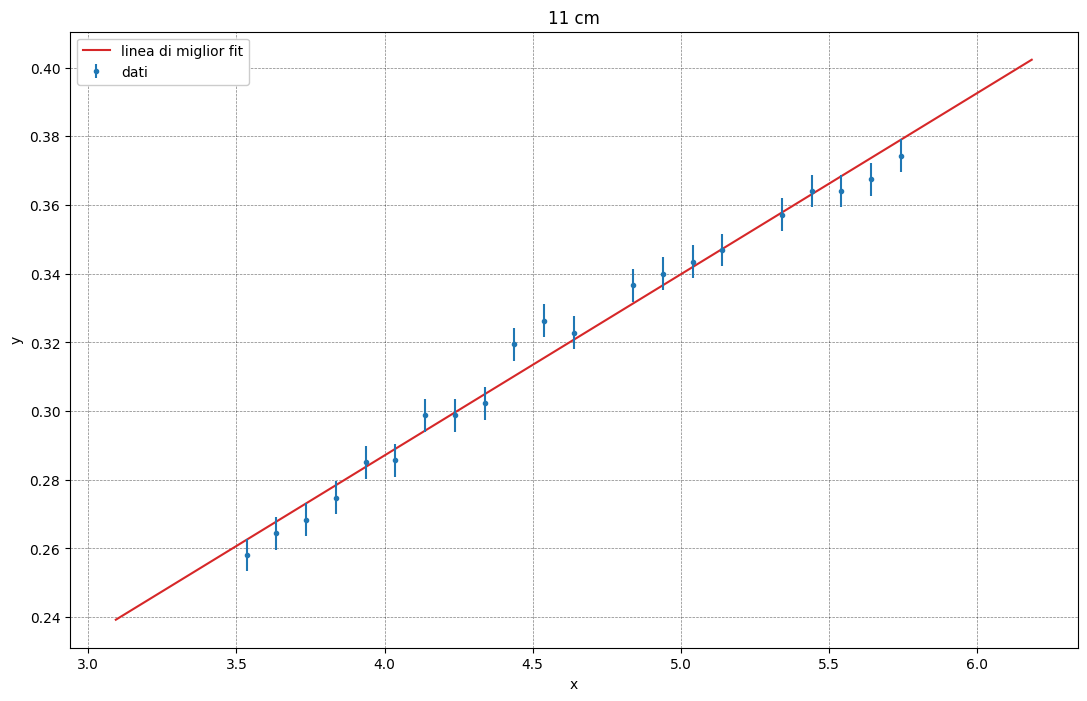

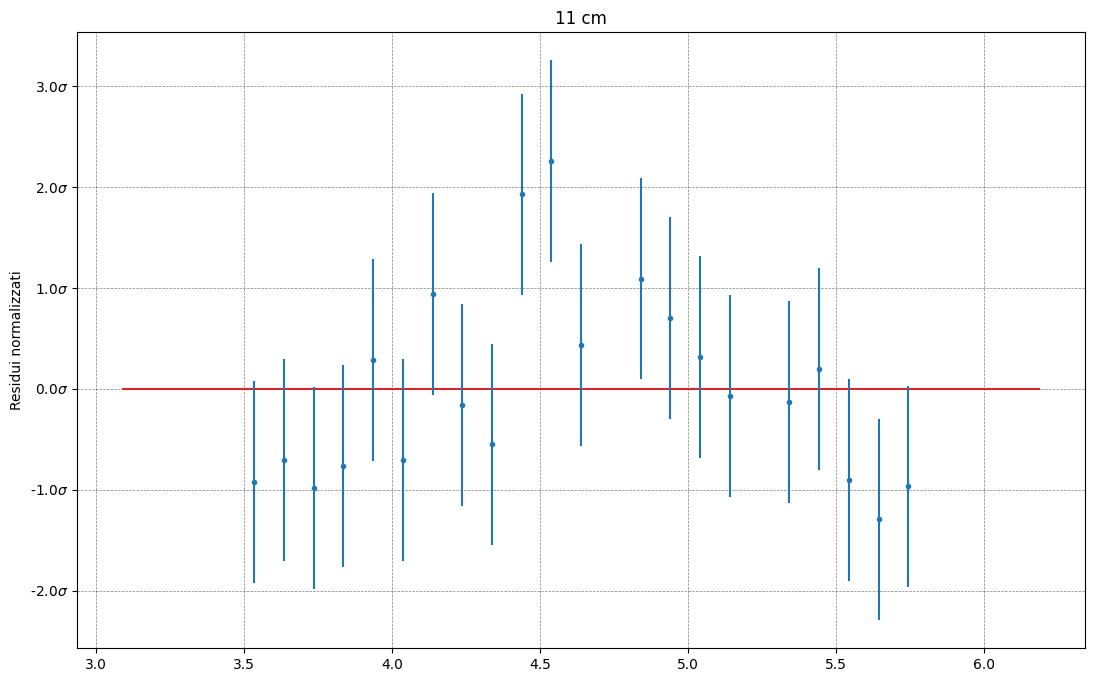

In [414]:
altezze = [11,12,13,14,15,16,18,20]
indici_da_togliere={11:[12,17],12:[0,8,13,14,18,22,-1],13:[6,10,14],14:[6,15],15:[1,4,11,-1],16:[3,4,5,9,12,-1],18:[2,3,4,7,-4],20:[3,-3]}
intervalli = {11:(3.5,5.8),12:(2,4.7),13:(1.8,4),14:(1.5,3.51),15:(1.5,5),16:(1,2.7),18:(1.1,2.6),20:(1.4,2.6)}
acc = []
sigma_acc = []
mostra = [11]

for h in altezze:
    toglivirgole(f'Labm/angoli/{h} cm/Delta T {h}.txt')
    df = pd.read_csv(f'Labm/angoli/{h} cm/Delta T {h}.txt',header=1,sep='\t') #il separatore in questo caso era un "tab" (\t)
    df = df.rename(columns={"Tempo ( s )": "t", "Tempo trascorso ( s )": "DeltaT"})
    df = df.drop(df[df.t <intervalli[h][0] ].index | df[df.t > intervalli[h][1]].index)
    #df.plot(x="t",y="DeltaT",linestyle="None",marker=".")
    t = df.t.to_numpy()
    DeltaT = df.DeltaT.to_numpy()
    Pos,_ = XdaDeltaT(DeltaT)
    V = np.array([(Pos[i+1]-Pos[i])/(t[i+1]-t[i]) for i in range(0,len(Pos)-1,2)])
    T = np.array([(t[i+1]+t[i])/(2) for i in range(0,len(t)-1,2)])
    sigmaV = np.array([IncertezzaV(DeltaT[i],DeltaT[i+1],t[i],t[i+1]) for i in range(0,len(t)-1,2)])
    sigmaT = np.ones(len(T))*(0.0001)/(np.sqrt(24))
    
    
    if h in mostra:
        coeffic_di_corr = np.array([[(V[i]*V[j]*(0.38354076/172.4192597)**2)/(sigmaV[i]*sigmaV[j]) for j in range(len(V))] for i in range(len(V))])
        coeffic_di_corr = (coeffic_di_corr*(1-np.identity(len(V)))+np.identity(len(V))).round(2)
        AAA = pd.DataFrame(coeffic_di_corr)
        fit_iter(T,V,sigmaT,sigmaV,nuoveincertezze=False,titolo = f'{h} cm')
        residui(T,V,sigmaT,sigmaV,titolo = f'{h} cm')
        
    ind = indici_da_togliere[h]
    V,T,sigmaT,sigmaV = np.delete(V,ind),np.delete(T,ind),np.delete(sigmaT,ind),np.delete(sigmaV,ind)
    m,sigma_m,c,sigma_c,cov_mc,sigma_post =fit_post(T,V,sigmaT,sigmaV,plot=h in mostra,titolo = f'{h} cm')
    acc.append(m); sigma_acc.append(sigma_m)

pd.set_option('display.precision', 2)
#AAA.style
AAA.style.format( precision=2).apply(background_gradient, axis=None)




m = 9.770709234761778 +/- 0.1576488634057203
c = -0.03603590541512028 +/- 0.004719018525303092
Cov(m,c) = -0.0006564388325179253



array([0.05273174, 0.11195882, 0.16166213, 0.21425582, 0.2648732 ,
       0.32837866, 0.42476689, 0.53918827])

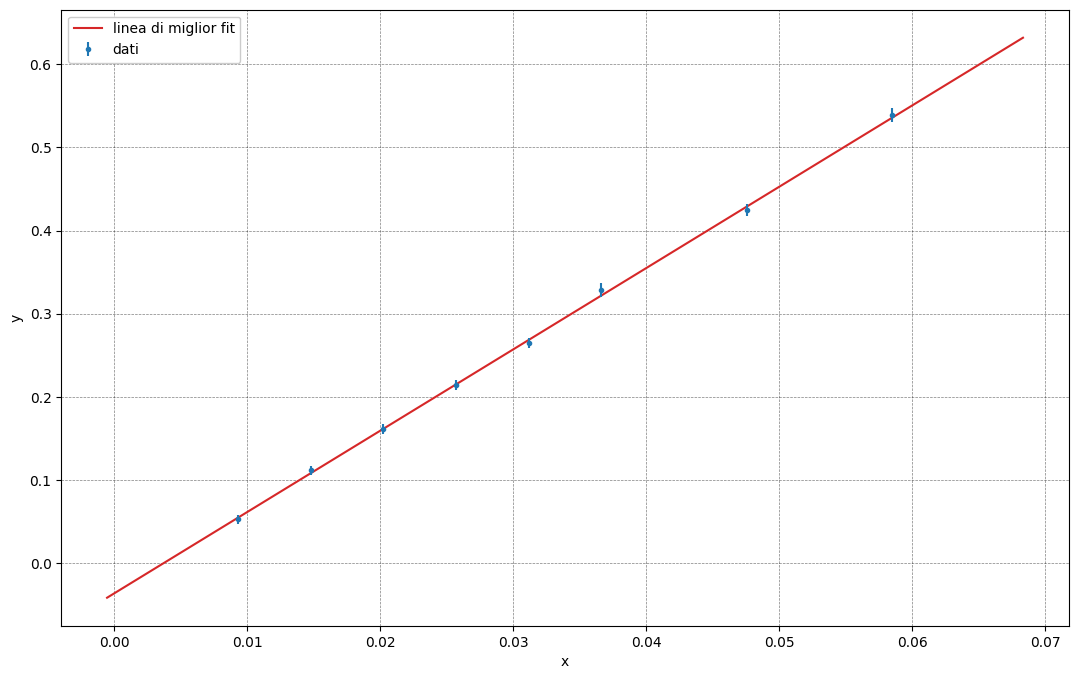

In [379]:
L = 183
h0 = 9.3
altezze = np.array(altezze)
theta = np.arcsin(((altezze)-h0)/L)
sigma_theta = (1/L)*(1/(np.sqrt(1-((altezze-h0)/L)**2)))*0.1
acc = np.array(acc)
#acc = np.array([0.05273174, 0.11195882, 0.16166213, 0.21425582, 0.2648732 , 0.33287072, 0.4476689, 0.54918827])
sigma_acc = np.array(sigma_acc)
fit_iter(theta,acc,sigma_theta,sigma_acc)
acc

# Riproducibilità


C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\2318189440.py:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df = df.drop(df[df.t <1.01 ].index | df[df.t > 2].index)
C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\3492270241.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(ticklabels)


m = 0.544676530594447 +/- 0.0032630829319710616
c = -0.011160240169917766 +/- 0.004845513856931878
Cov(m,c) = -1.5576812215662946e-05


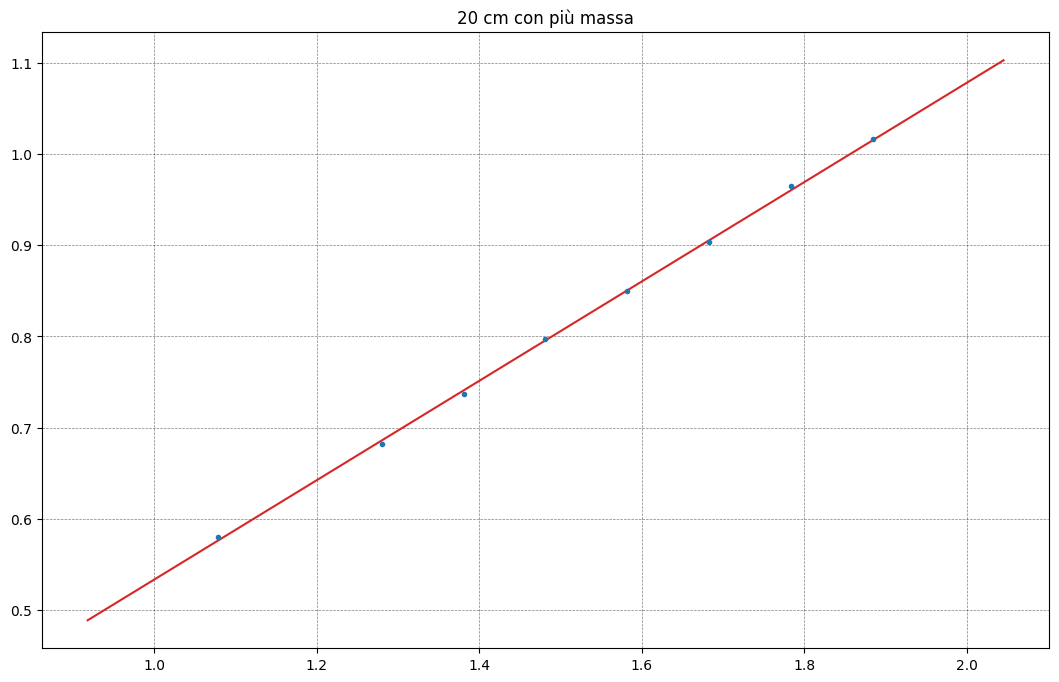

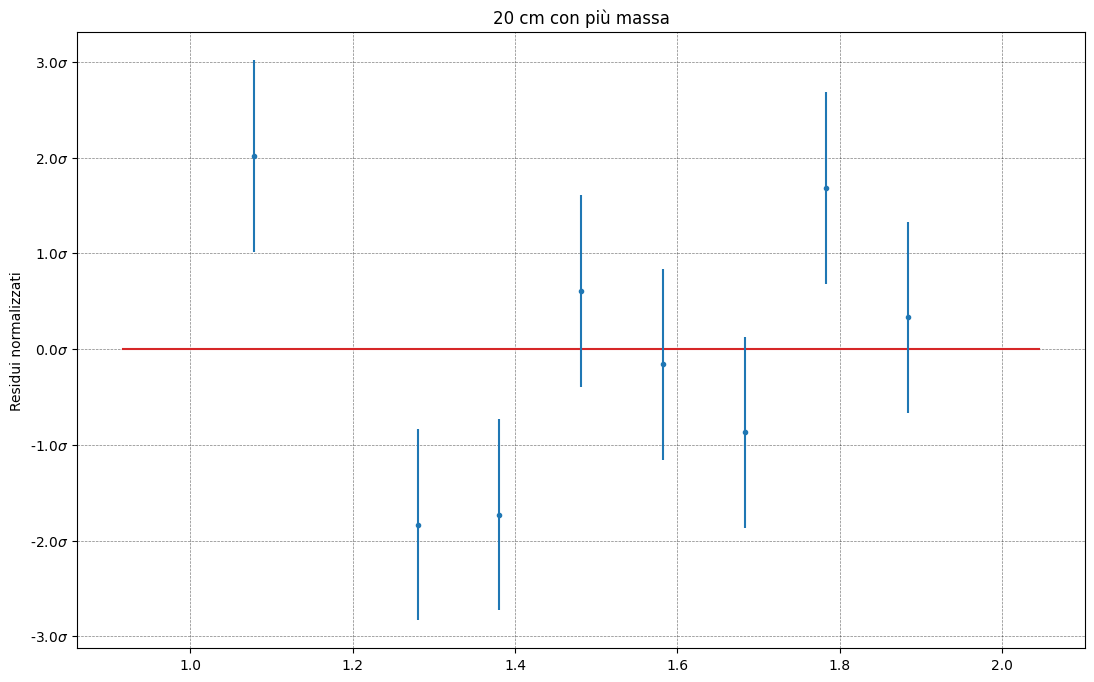

In [390]:
toglivirgole('Labm/angoli/20 cm/z Delta t 20 M.txt')
df = pd.read_csv('Labm/angoli/20 cm/z Delta t 20 M.txt',header=1,sep='\t') #il separatore in questo caso era un "tab" (\t)
df = df.rename(columns={"Tempo ( s )": "t", "Tempo trascorso ( s )": "DeltaT"})
df = df.drop(df[df.t <1.01 ].index | df[df.t > 2].index)
#df.plot(x="t",y="DeltaT",linestyle="None",marker=".")
t = df.t.to_numpy()
DeltaT = df.DeltaT.to_numpy()
Pos,_ = XdaDeltaT(DeltaT)
V = np.array([(Pos[i+1]-Pos[i])/(t[i+1]-t[i]) for i in range(0,len(Pos)-1,2)])
T = np.array([(t[i+1]+t[i])/(2) for i in range(0,len(t)-1,2)])
sigmaV = np.array([IncertezzaV(DeltaT[i],DeltaT[i+1],t[i],t[i+1]) for i in range(0,len(t)-1,2)])
sigmaT = np.ones(len(T))*(0.0001)/(np.sqrt(24))
ind = [1]
V,T,sigmaT,sigmaV = np.delete(V,ind),np.delete(T,ind),np.delete(sigmaT,ind),np.delete(sigmaV,ind)
fit_iter(T,V,sigmaT,sigmaV,nuoveincertezze=False,titolo = '20 cm con più massa')
residui(T,V,sigmaT,sigmaV,titolo = '20 cm con più massa')

m = 0.5123913476416071 +/- 0.0022673204365921446
c = 0.005423153399508607 +/- 0.003473146867570026
Cov(m,c) = -7.710539025756588e-06
m = 0.5427984048236464 +/- 0.011128115728503196
c = -0.029870801659390732 +/- 0.01887869656907279
Cov(m,c) = -0.00020652045020421575



C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\4101355506.py:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df = df.drop(df[df.t <1.01 ].index | df[df.t > 2.2].index)
C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\3492270241.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(ticklabels)


(0.5427984048236464,
 0.011128115728503196,
 -0.029870801659390732,
 0.01887869656907279,
 -0.00020652045020421575,
 0.00916115909919999)

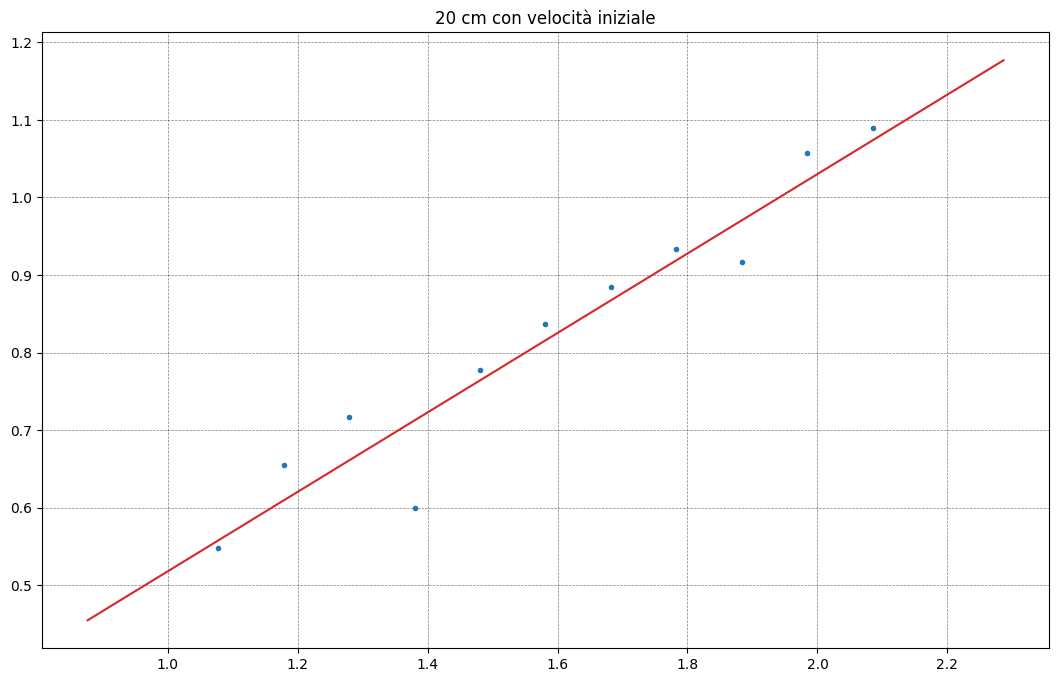

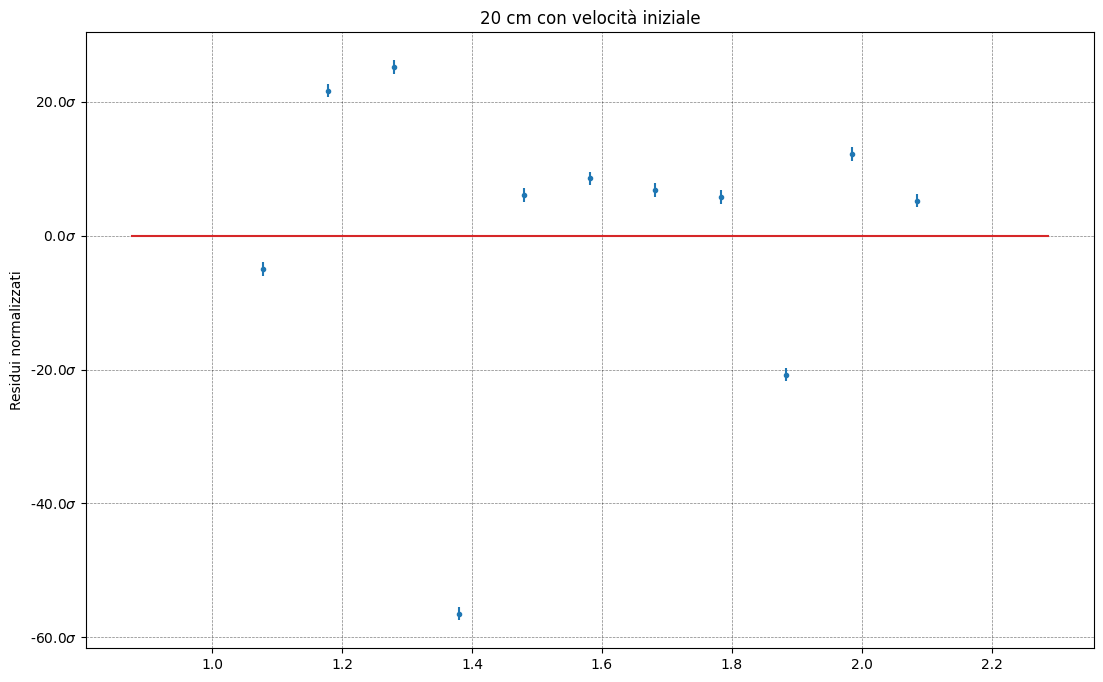

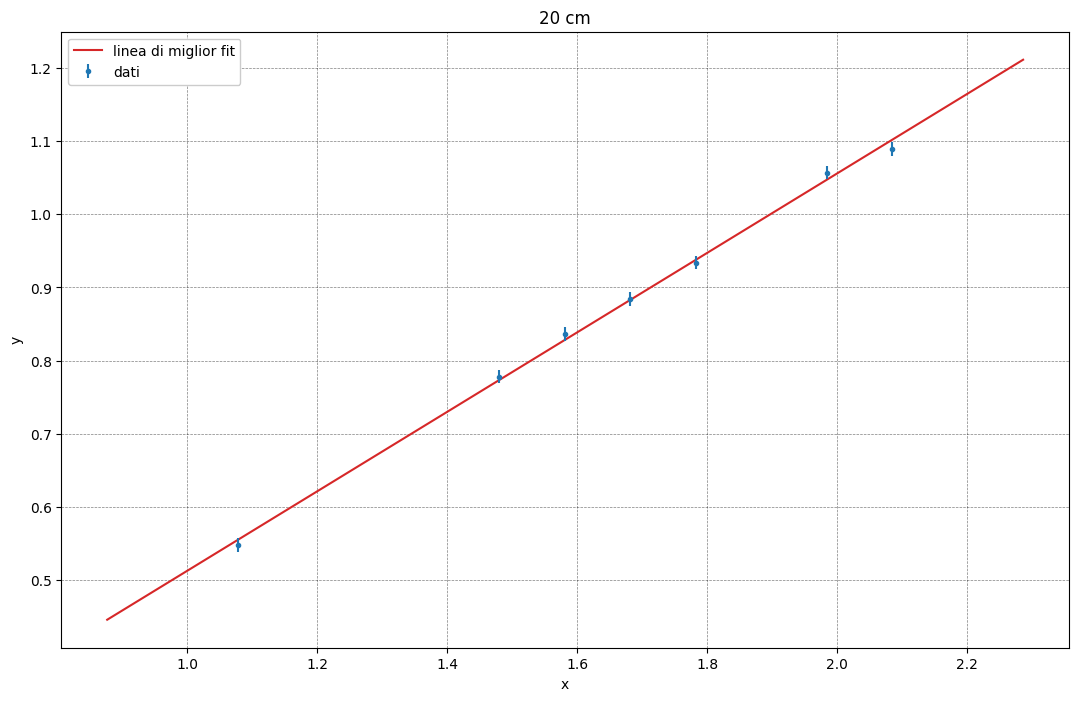

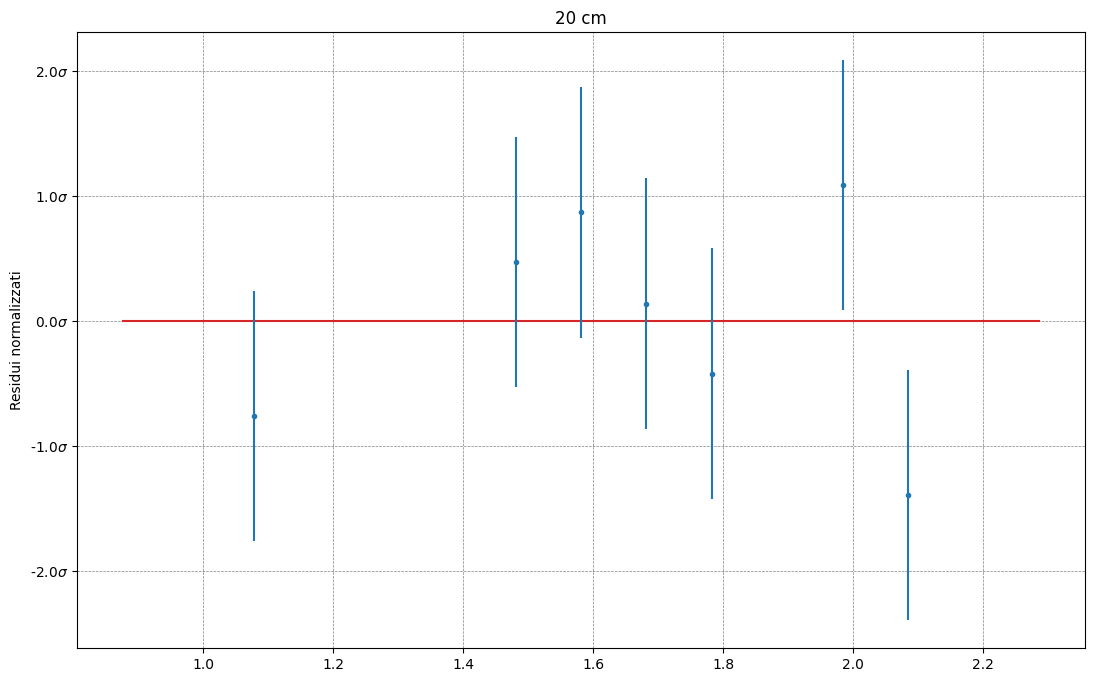

In [391]:
toglivirgole('Labm/angoli/20 cm/zz Delta t 20 Vi.txt')
df = pd.read_csv('Labm/angoli/20 cm/zz Delta t 20 Vi.txt',header=1,sep='\t') #il separatore in questo caso era un "tab" (\t)
df = df.rename(columns={"Tempo ( s )": "t", "Tempo trascorso ( s )": "DeltaT"})
df = df.drop(df[df.t <1.01 ].index | df[df.t > 2.2].index)
#df.plot(x="t",y="DeltaT",linestyle="None",marker=".")
t = df.t.to_numpy()
DeltaT = df.DeltaT.to_numpy()
Pos,_ = XdaDeltaT(DeltaT)
V = np.array([(Pos[i+1]-Pos[i])/(t[i+1]-t[i]) for i in range(0,len(Pos)-1,2)])
T = np.array([(t[i+1]+t[i])/(2) for i in range(0,len(t)-1,2)])
sigmaV = np.array([IncertezzaV(DeltaT[i],DeltaT[i+1],t[i],t[i+1]) for i in range(0,len(t)-1,2)])
sigmaT = np.ones(len(T))*(0.0001)/(np.sqrt(24))

fit_iter(T,V,sigmaT,sigmaV,nuoveincertezze=False,titolo = '20 cm con velocità iniziale')
residui(T,V,sigmaT,sigmaV,titolo = '20 cm con velocità iniziale')

ind = [1,2,3,8]
V,T,sigmaT,sigmaV = np.delete(V,ind),np.delete(T,ind),np.delete(sigmaT,ind),np.delete(sigmaV,ind)

fit_post(T,V,sigmaT,sigmaV,plot=h in mostra,titolo = f'{h} cm')

m = 0.5233549736706911 +/- 0.001473302209076731
c = -0.21174658351971193 +/- 0.0024906609920574115
Cov(m,c) = -3.5715682991877297e-06
m = 0.5322210481737454 +/- 0.033006489035527886
c = -0.22302945679827174 +/- 0.060312783986910985
Cov(m,c) = -0.0019410422152022076



C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\2449084823.py:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df = df.drop(df[df.t <1.1 ].index | df[df.t > 2.502].index)
C:\Users\nicco\AppData\Local\Temp\ipykernel_25236\3492270241.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(ticklabels)


(0.5322210481737454,
 0.033006489035527886,
 -0.22302945679827174,
 0.060312783986910985,
 -0.0019410422152022076,
 0.05009674540270124)

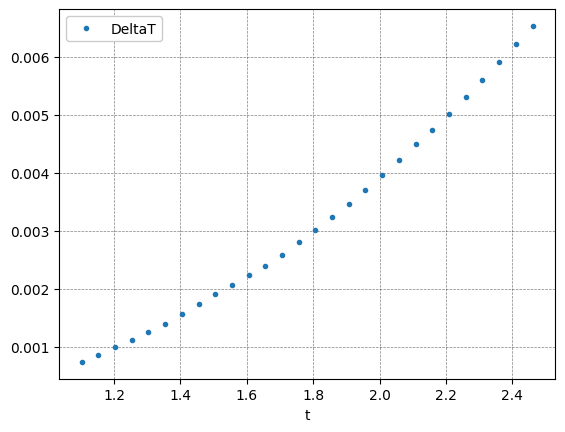

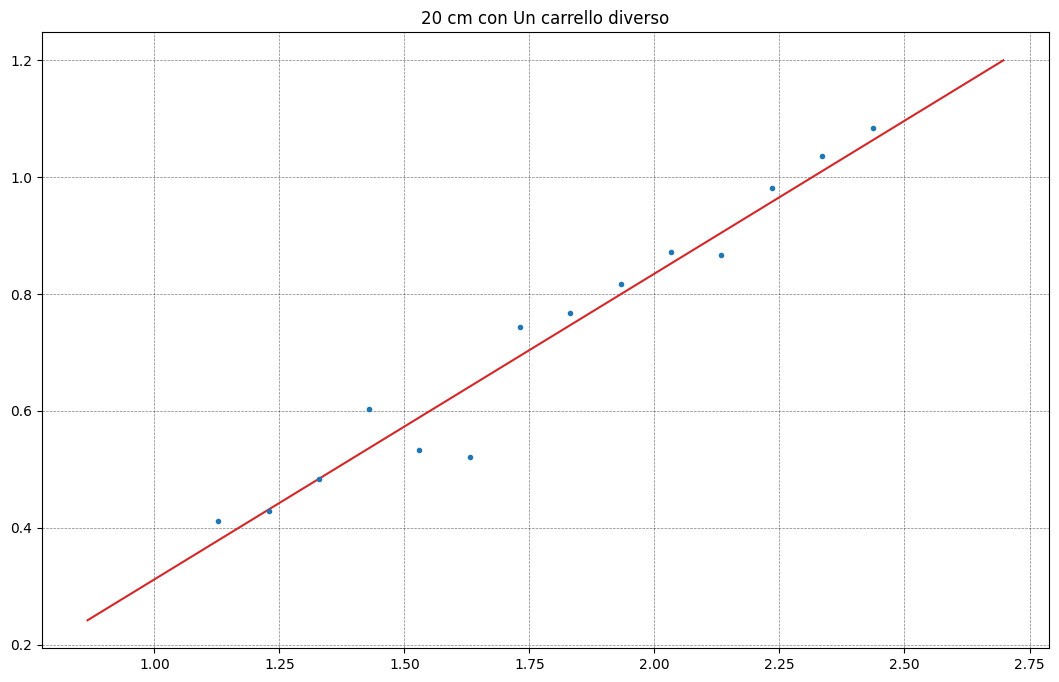

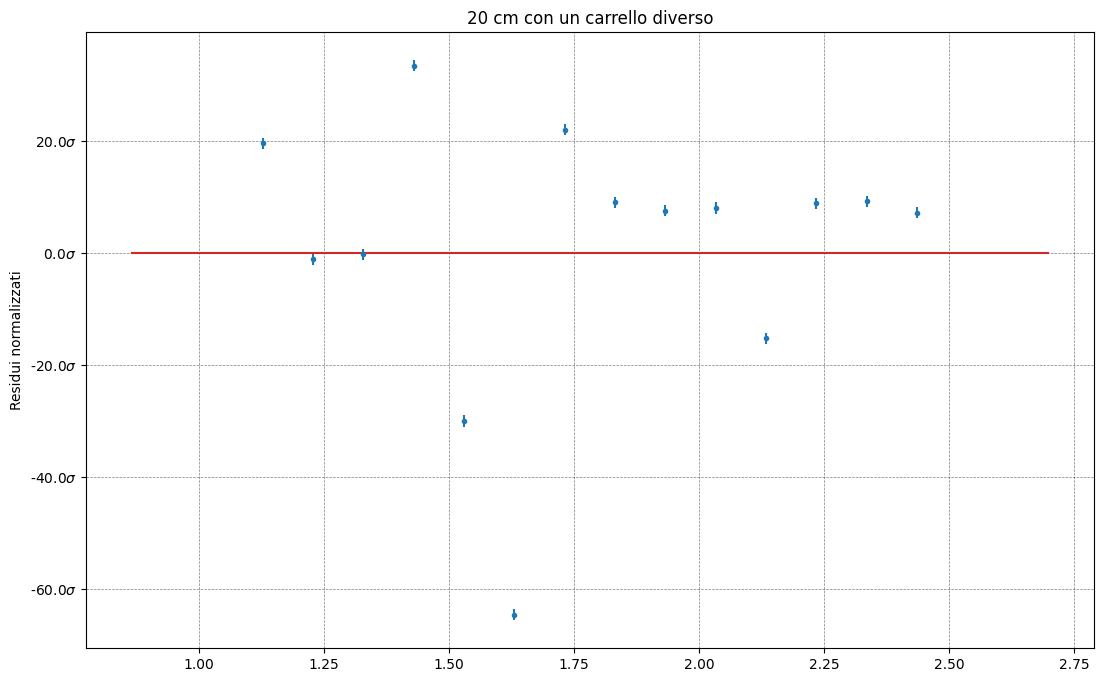

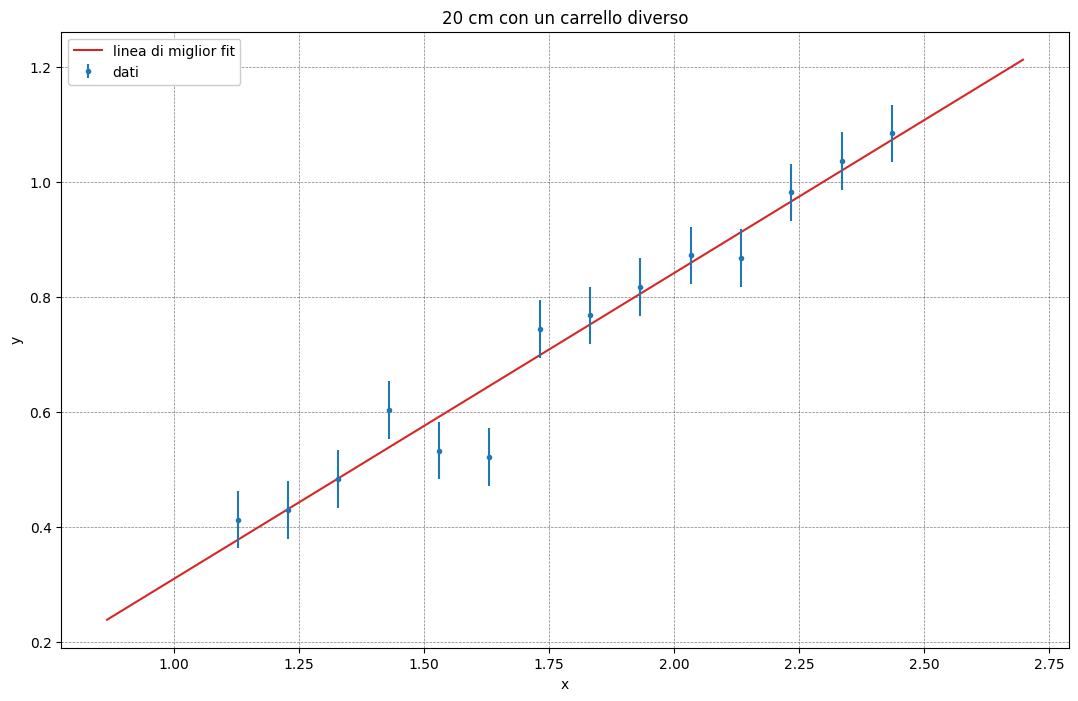

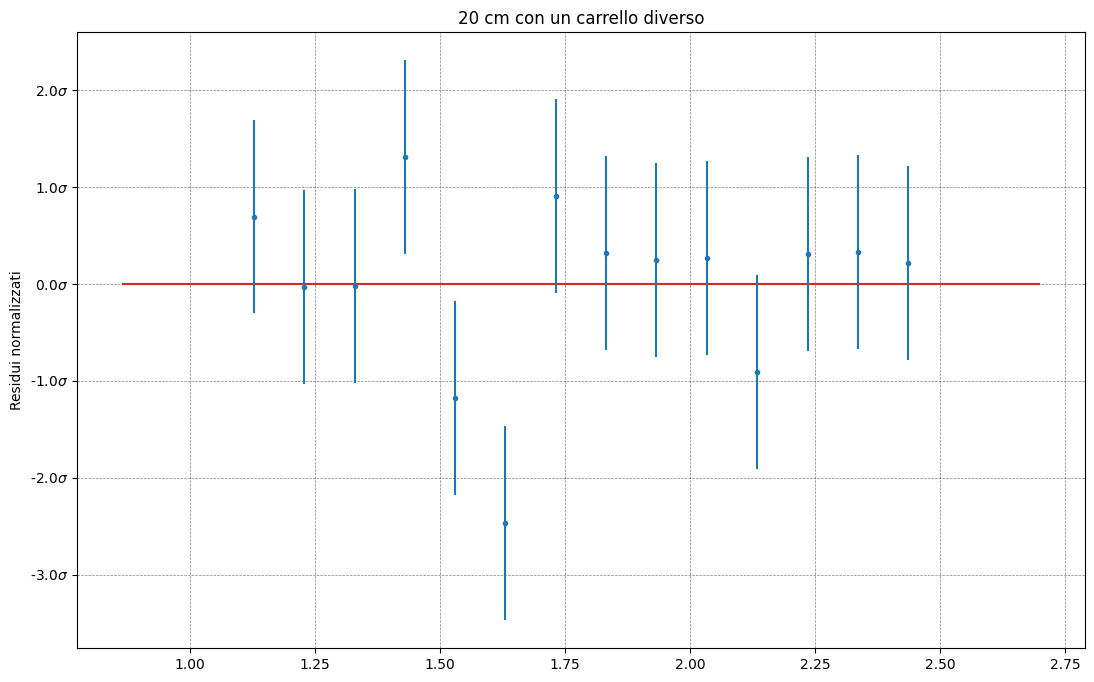

In [408]:
toglivirgole('Labm/angoli/20 cm/zzz Delta t 20 Car.txt')
df = pd.read_csv('Labm/angoli/20 cm/zzz Delta t 20 Car.txt',header=1,sep='\t') #il separatore in questo caso era un "tab" (\t)
df = df.rename(columns={"Tempo ( s )": "t", "Tempo trascorso ( s )": "DeltaT"})
df = df.drop(df[df.t <1.1 ].index | df[df.t > 2.502].index)
df.plot(x="t",y="DeltaT",linestyle="None",marker=".")
t = df.t.to_numpy()
DeltaT = df.DeltaT.to_numpy()
Pos,_ = XdaDeltaT(DeltaT)
V = np.array([(Pos[i+1]-Pos[i])/(t[i+1]-t[i]) for i in range(0,len(Pos)-1,2)])
T = np.array([(t[i+1]+t[i])/(2) for i in range(0,len(t)-1,2)])
sigmaV = np.array([IncertezzaV(DeltaT[i],DeltaT[i+1],t[i],t[i+1]) for i in range(0,len(t)-1,2)])
sigmaT = np.ones(len(T))*(0.0001)/(np.sqrt(24))

fit_iter(T,V,sigmaT,sigmaV,nuoveincertezze=False,titolo = '20 cm con Un carrello diverso')
residui(T,V,sigmaT,sigmaV,titolo = '20 cm con un carrello diverso')
#ind = [None]
#V,T,sigmaT,sigmaV = np.delete(V,ind),np.delete(T,ind),np.delete(sigmaT,ind),np.delete(sigmaV,ind)
#ind = [0,4]
#V,T,sigmaT,sigmaV = np.delete(V,ind),np.delete(T,ind),np.delete(sigmaT,ind),np.delete(sigmaV,ind)

fit_post(T,V,sigmaT,sigmaV,plot=h in mostra,titolo = '20 cm con un carrello diverso')